In [1]:
!nvidia-smi

Wed Dec 30 01:29:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:08:00.0 Off |                  N/A |
| 23%   31C    P8     9W / 250W |     68MiB / 12188MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import numpy as np
import vggish_params
import vggish_keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import Accuracy, Precision, Recall
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from statistics import mode
from tqdm import tqdm, trange
import time

In [3]:
sfreq = 1000
sec = 10

In [200]:
y_train[18]

'alarm-clock'

In [240]:
X_train = np.load('temporal_data/{}sec/features_train_{}.npy'.format(sec, sfreq), allow_pickle=True)
y_train = np.load('temporal_data/{}sec/labels_train_{}.npy'.format(sec, sfreq), allow_pickle=True)

speech_index = 23
alarm_clock_index = 18
water_running_index = 8

X_train = list(X_train)
y_train = list(y_train)
del X_train[speech_index], y_train[speech_index]
del X_train[alarm_clock_index], y_train[alarm_clock_index]
del X_train[water_running_index], y_train[water_running_index]

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)    

valid_idx = []
for i in range(len(X_train)):
    if len(X_train[i].shape) == 3:
        valid_idx.append(i)
    elif len(X_train[i].shape) != 1:
        print('ghotala! @ {}'.format(i))

X_train = X_train[valid_idx]
y_train = y_train[valid_idx]

shuffled_idx = np.arange(len(X_train))
np.random.shuffle(shuffled_idx)

X_train = X_train[shuffled_idx]
y_train = y_train[shuffled_idx]

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

NUM_BANDS = X_train.shape[1]
NUM_FRAMES = X_train.shape[2]
# NUM_BANDS = X_train[0].shape[1]
# NUM_FRAMES = X_train[0].shape[2]

In [180]:
X_train.shape

(102752, 64, 101)

In [181]:
i=100001
print(X_train[i].shape)
y_train[i]

(64, 101)


'saw'

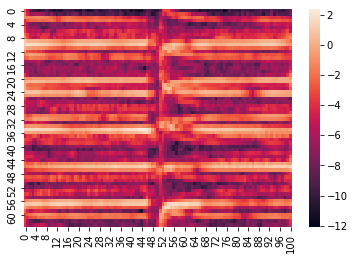

In [241]:
sns.heatmap(X_train[i])

In [242]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)
class_weights = dict(enumerate(weights))
class_name_weights = {np.unique(y_train)[key]:class_weights[key] for key in class_weights.keys()}
class_name_weights

/home/dhruv/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=['alarm-clock' 'baby-cry' 'blender' 'cat-meow' 'chopping' 'cooking'
 'cough' 'dishwasher' 'dog-bark' 'door' 'drill' 'engine' 'flush'
 'hair-dryer' 'hammer' 'hazard-alarm' 'knock' 'laugh' 'microwave'
 'phone-ring' 'saw' 'shaver' 'snore' 'toothbrush' 'typing' 'vacuum'
 'water-running'], y=['toothbrush' 'toothbrush' 'toothbrush' ... 'hazard-alarm' 'hazard-alarm'
 'hazard-alarm'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{'alarm-clock': 2.5506521306252488,
 'baby-cry': 1.7827009724614233,
 'blender': 3.8144425832868043,
 'cat-meow': 16.35935504469987,
 'chopping': 10.067295412122998,
 'cooking': 4.007782862059525,
 'cough': 39.53510802469136,
 'dishwasher': 0.6533603667361629,
 'dog-bark': 1.1860532407407407,
 'door': 94.88425925925925,
 'drill': 1.7538680084890805,
 'engine': 0.24964614683749065,
 'flush': 1.4284419911066506,
 'hair-dryer': 0.7950084562987789,
 'hammer': 1.1624411547841869,
 'hazard-alarm': 0.29558959270797275,
 'knock': 55.00536768652711,
 'laugh': 18.514001806684732,
 'microwave': 1.8559268314769537,
 'phone-ring': 3.0002927829014787,
 'saw': 2.5489391338954803,
 'shaver': 1.4536079549484375,
 'snore': 5.206269369506681,
 'toothbrush': 10.230108815014475,
 'typing': 0.8490761454967272,
 'vacuum': 0.4179463022101498,
 'water-running': 0.158642800968499}

In [243]:
ohe = OneHotEncoder()
NUM_CLASSES = len(weights)
NUM_FILES = len(y_train)

y_train = ohe.fit_transform(y_train.reshape((-1,1))).toarray().reshape((-1, NUM_CLASSES))

X_train = X_train.reshape((-1, NUM_FRAMES, NUM_BANDS, 1))

# y_ohe = []
# for i in tqdm(range(NUM_FILES)):
#     file_ohe = ohe.transform(np.array(y_train[i]).reshape((-1,1))).toarray().reshape((-1, NUM_CLASSES))
#     y_ohe.append(file_ohe)              
#     X_train[i] = X_train[i].reshape((-1, NUM_BANDS, NUM_FRAMES, 1))
    
# y_train = np.array(y_ohe)

In [228]:
X_test.shape

(533,)

In [244]:
X_test = np.load('temporal_data/{}sec/features_test_{}.npy'.format(sec, sfreq), allow_pickle=True)
y_test = np.load('temporal_data/{}sec/labels_test_{}.npy'.format(sec, sfreq), allow_pickle=True)

X_test = list(X_test)
y_test = list(y_test)
del X_test[speech_index], y_test[speech_index]
del X_test[alarm_clock_index], y_test[alarm_clock_index]
del X_test[water_running_index], y_test[water_running_index]

# X_test = np.concatenate(X_test)
# y_test = np.concatenate(y_test)      

X_valid_test = []
y_valid_test = []

for lbl in range(len(class_name_weights.keys())):
    for i in range(len(X_test[lbl])):
        if len(X_test[lbl][i].shape) == 3:
            X_valid_test.append(X_test[lbl][i])
            y_valid_test.append(y_test[lbl][i])
        
        elif len(X_test[lbl][i].shape) != 1:
            print('ghotala! @ {}'.format(i))

X_test = np.array(X_valid_test)
y_test = np.array(y_valid_test)
   
shuffled_idx = np.arange(len(X_test))
np.random.shuffle(shuffled_idx)

X_test = X_test[shuffled_idx]
y_test = y_test[shuffled_idx]

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

NUM_TEST_FILES = len(y_test)

y_test = ohe.fit_transform(y_test.reshape((-1,1))).toarray().reshape((-1, NUM_CLASSES))
X_test = X_test.reshape((-1, NUM_FRAMES, NUM_BANDS, 1))

# y_ohe = []
# for i in tqdm(range(NUM_TEST_FILES)):
#     file_ohe = ohe.transform(np.array(y_test[i]).reshape((-1,1))).toarray().reshape((-1, NUM_CLASSES))
#     y_ohe.append(file_ohe)              
#     X_test[i] = X_test[i].reshape((-1, NUM_BANDS, NUM_FRAMES, 1))

# y_test = np.array(y_ohe)

In [236]:
X_test.shape
X_train.shape
y_test.shape

(27266, 27)

In [245]:
idx = 13
print('X train shape {}'.format(X_train.shape))
print('X test  shape {}'.format(X_test.shape))
print('y train shape {}'.format(y_train.shape))
print('y test  shape {}'.format(y_test.shape))

X train shape (102475, 101, 64, 1)
X test  shape (27266, 101, 64, 1)
y train shape (102475, 27)
y test  shape (27266, 27)


In [272]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM, Reshape, Bidirectional, Lambda, GlobalAveragePooling1D
from keras.models import Model
import keras.backend as K

def softmax_pool(x):
    x_sum_sq = K.sum(K.square(x), axis=1)
    x_sum = K.sum(x, axis=1)
    return x_sum_sq/x_sum 

def softmax_pool_output_shape(input_shape):
    shape = list(input_shape)
    return tuple(shape[2])

# Input
input_shape = (NUM_FRAMES, NUM_BANDS, 1)
batch_input_shape = (1, NUM_BANDS, NUM_FRAMES, 1)
img_input = Input(shape = input_shape, name='input')

# Block 1
x = Conv2D(32, (5, 5), activation='relu', padding='same', name='conv1')(img_input)
x = MaxPooling2D((1, 2), strides=(1, 2), name='pool1')(x)

# Block 2
x = Conv2D(64, (5, 5), activation='relu', padding='same', name='conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

# Block 3
x = Conv2D(128, (5, 5), activation='relu', padding='same', name='conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

# LSTM
x = Reshape((25, -1), name='flatten')(x)
x = Bidirectional(LSTM(units = 100, return_sequences=True), name='bi_lstm')(x)

# # Block fc
# x = Dropout(0.4)(x)
x = Dense(NUM_CLASSES, activation='sigmoid', name='frame_level_pred')(x)
x = Lambda(softmax_pool, output_shape = softmax_pool_output_shape, name='recording_level_pred')(x)
# x = GlobalAveragePooling1D()(x)
model = Model(img_input, x, name='model')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 101, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 101, 64, 32)       832       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 101, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 101, 32, 64)       51264     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 16, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 50, 16, 128)       204928    
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 25, 8, 128)        0     

In [273]:
MODEL_NAME = 'talnet_{}_{}'.format(sec, sfreq)

BATCH_SIZE = 64

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.load_weights('checkpoints/model_{}.h5'.format(sfreq))

checkpoint = ModelCheckpoint('checkpoints/{}.h5'.format(MODEL_NAME), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1, min_lr=0.000001)

In [274]:
history = model.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                    class_weight=class_weights, callbacks= [checkpoint, earlystopping, reducelr], shuffle=True)

Epoch 1/100
1600/1602 [============================>.] - ETA: 0s - loss: 0.1608 - accuracy: 0.0080
Epoch 00001: val_accuracy improved from -inf to 0.00583, saving model to checkpoints/talnet_10_1000.h5
1602/1602 [==============================] - 38s 24ms/step - loss: 0.1608 - accuracy: 0.0081 - val_loss: 0.1598 - val_accuracy: 0.0058
Epoch 2/100
1600/1602 [============================>.] - ETA: 0s - loss: 0.1603 - accuracy: 0.0073
Epoch 00002: val_accuracy improved from 0.00583 to 0.04992, saving model to checkpoints/talnet_10_1000.h5
1602/1602 [==============================] - 38s 24ms/step - loss: 0.1603 - accuracy: 0.0073 - val_loss: 0.1585 - val_accuracy: 0.0499
Epoch 3/100
1600/1602 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.0103
Epoch 00003: val_accuracy did not improve from 0.04992
1602/1602 [==============================] - 38s 24ms/step - loss: 0.1602 - accuracy: 0.0103 - val_loss: 0.1630 - val_accuracy: 0.0014
Epoch 4/100
1600/1602 [===========

KeyboardInterrupt: 

In [ ]:
NUM_EPOCHS = 1

for epoch in range(NUM_EPOCHS):
    for file in range(NUM_FILES):
        NUM_FRAMES = X_train[file].shape[0]
        for frame in range(NUM_FRAMES):
        X_file_train = X_train[file][frame:frame+1]
        y_file_train = y_train[file][frame:frame+1]
        history = model.fit(X_file_train, y_file_train, epochs=1, batch_size=1, 
                    class_weight=class_weights, callbacks= [checkpoint, earlystopping, reducelr], shuffle=True)

In [ ]:
plt.plot(history.history['val_accuracy'])

### Contextual Results

In [54]:
model.load_weights('checkpoints/{}.h5'.format(MODEL_NAME))
print('Loaded best checkpoint!')

Loaded best checkpoint!


In [55]:
MODEL_NAME

'convlstm_2_1000'

In [ ]:
labels_test = ohe.inverse_transform(y_test).flatten()

In [ ]:
pred = model.predict(X_test)

In [ ]:
np.unique(labels_test)

In [ ]:
encoding = {label: ohe.transform(np.array(label).reshape(-1,1)).toarray() for label in np.unique(labels_test)}

contexts = {
    'monolithic': ['alarm-clock', 'baby-cry', 'blender', 'car-horn', 'cat-meow',
       'chopping', 'cooking', 'cough', 'dishwasher', 'dog-bark', 'door',
       'doorbell', 'drill', 'engine', 'flush', 'hair-dryer', 'hammer',
       'hazard-alarm', 'knock', 'laugh', 'microwave', 'phone-ring', 'saw',
       'shaver', 'snore', 'speech', 'toothbrush', 'typing', 'vacuum',
       'water-running'],
    'bathroom': ['water-running', 'shaver', 'toothbrush', 'flush', 'hair-dryer'],
    'kitchen': ['hazard-alarm', 'speech', 'chopping', 'water-running', 'microwave', 'blender', 'dishwasher', 'cooking'],
    'bedroom': ['speech', 'baby-cry', 'cough', 'snore', 'alarm-clock'],
    'office': ['phone-ring', 'speech', 'cough', 'door', 'knock', 'typing'],
    'entrance': ['speech', 'door', 'knock', 'doorbell', 'laugh'],
    'workshop': ['drill', 'hazard-alarm', 'speech', 'vacuum', 'hammer', 'saw'],
    'outdoor': ['dog-bark', 'hazard-alarm', 'speech', 'car-horn', 'engine', 'cat-meow']
}

context_encoding = {}
for context in contexts.keys():
    context_encoding[context] = np.zeros((1,30))
    for activity in contexts[context]:
        context_encoding[context] += encoding[activity]    

In [ ]:
for context in contexts.keys():
#     context = list(contexts.keys())[0]
    valid_idx = [i for i, label in enumerate(labels_test) if label in contexts[context]]
    valid_pred = pred[valid_idx]
    valid_labels = labels_test[valid_idx]
    valid_pred = np.argmax(valid_pred * context_encoding[context], axis=1)
    valid_pred = [ohe.categories_[0][pr] for pr in valid_pred]
    acc = accuracy_score(valid_labels, valid_pred)
    f1 = f1_score(valid_labels, valid_pred, average='weighted')
    conf_mat = confusion_matrix(valid_labels, valid_pred, normalize='true')
    label_names = np.unique(valid_labels)
    print('{},{},{},{},{}'.format(sfreq,context,acc,f1,sec))
    # fig, ax = plt.subplots(figsize=(13,10))
    # sns.heatmap(conf_mat, cmap='Blues', ax=ax, xticklabels=label_names, yticklabels=label_names, annot=False)
    # ax.set_title('sFreq: {}, Context: {}, Acc: {}'.format(sfreq,context,acc))
    # ax.set_xlabel('Predicted Label')
    # ax.set_ylabel('True Label')

In [70]:
len(X_train)

12224

### File-Level Metrics 

In [ ]:
num_bands = 64
X_test = np.load('temporal_data/{}sec/features_test_{}.npy'.format(sec, sfreq), allow_pickle=True)
y_test = np.load('temporal_data/{}sec/labels_test_{}.npy'.format(sec, sfreq), allow_pickle=True)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)    

valid_idx = []
for i in range(len(X_test)):
    if len(X_test[i] == 3):
        valid_idx.append(i)
    elif len(X_test[i] != 0):
        print('ghotala! @ {}'.format(i))

X_test = X_test[valid_idx]
y_test = y_test[valid_idx]

X_test = [file.reshape((-1, NUM_BANDS, NUM_FRAMES, 1)) for file in X_test]
y_test = [ohe.transform(np.array(file).reshape(-1,1)).toarray().reshape((-1, NUM_CLASSES)) for file in y_test]

In [ ]:
model.load_weights('checkpoints/{}.h5'.format(MODEL_NAME))
print('Loaded best checkpoint!')

In [ ]:
labels_test = np.array([ohe.inverse_transform(file).flatten() for file in y_test])

In [ ]:
pred = np.array([model.predict(file) for file in X_test])

In [ ]:
pred_time = []
for file in tqdm(X_test):
    for i in range(len(file)):
        frame = file[i:i+1]
        st = time.time()
        prediction = model.predict(frame)
        en = time.time()
        pred_time.append(en-st)

In [ ]:
print('{},{}'.format(sfreq, np.mean(pred_time)))

In [ ]:
encoding = {label: ohe.transform(np.array(label).reshape(-1,1)).toarray() for label in np.unique(np.concatenate(labels_test).flatten())}

contexts = {
    'monolithic': ['alarm-clock', 'baby-cry', 'blender', 'car-horn', 'cat-meow',
       'chopping', 'cooking', 'cough', 'dishwasher', 'dog-bark', 'door',
       'doorbell', 'drill', 'engine', 'flush', 'hair-dryer', 'hammer',
       'hazard-alarm', 'knock', 'laugh', 'microwave', 'phone-ring', 'saw',
       'shaver', 'snore', 'speech', 'toothbrush', 'typing', 'vacuum',
       'water-running'],
    'bathroom': ['water-running', 'shaver', 'toothbrush', 'flush', 'hair-dryer'],
    'kitchen': ['hazard-alarm', 'speech', 'chopping', 'water-running', 'microwave', 'blender', 'dishwasher', 'cooking'],
    'bedroom': ['speech', 'baby-cry', 'cough', 'snore', 'alarm-clock'],
    'office': ['phone-ring', 'speech', 'cough', 'door', 'knock', 'typing'],
    'entrance': ['speech', 'door', 'knock', 'doorbell', 'laugh'],
    'workshop': ['drill', 'hazard-alarm', 'speech', 'vacuum', 'hammer', 'saw'],
    'outdoor': ['dog-bark', 'hazard-alarm', 'speech', 'car-horn', 'engine', 'cat-meow']
}

context_encoding = {}
for context in contexts.keys():
    context_encoding[context] = np.zeros((1,30))
    for activity in contexts[context]:
        context_encoding[context] += encoding[activity]    

In [ ]:
for context in contexts.keys():
    valid_idx = [i for i, label in enumerate(labels_test) if label[0] in contexts[context]]
    valid_pred = pred[valid_idx]
    valid_labels = labels_test[valid_idx]
    valid_pred = [np.argmax(file * context_encoding[context], axis=1) for file in valid_pred]
    # Transform to per file level labels
    valid_pred = [ohe.categories_[0][mode(file)] for file in valid_pred]
    valid_labels = [file[0] for file in valid_labels]
    acc = accuracy_score(valid_labels, valid_pred)
    f1 = f1_score(valid_labels, valid_pred, average='weighted')
    conf_mat = confusion_matrix(valid_labels, valid_pred, normalize='true')
    label_names = np.unique(valid_labels)
    print('{},{},{},{}'.format(sfreq, context, acc, f1))
    fig, ax = plt.subplots(figsize=(13,10))
    sns.heatmap(conf_mat, cmap='Blues', ax=ax, xticklabels=label_names, yticklabels=label_names, annot=False)
    ax.set_title('sFreq: {}, Context: {}, Acc: {}'.format(sfreq,context,acc))
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')